In [1]:
import os, sys
import xarray as xr
import numpy as np
import pandas as pd
from importlib import reload
import re
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

Matplotlib created a temporary cache directory at /jobfs/135521015.gadi-pbs/matplotlib-0q3vxf33 because the default path (/home/563/ab2313/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Matplotlib is building the font cache; this may take a moment.


In [2]:
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'time_of_emergene_drafts'))
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'time_of_emergene_drafts', 'src'))
import climate_utils

import time_of_emergence_calc as toe
import my_stats

In [3]:
xr.set_options(display_expand_attrs=False)

In [4]:
from dask.distributed import Client, wait
# client.close()
client = Client(n_workers=50, threads_per_worker=1, memory_limit=None) 
client

 - State start
 -   Scheduler at:     tcp://127.0.0.1:34519
 -   dashboard at:         /proxy/8787/status
 - Registering Worker plugin shuffle
 -         Start Nanny at: 'tcp://127.0.0.1:43893'
 -         Start Nanny at: 'tcp://127.0.0.1:34357'
 -         Start Nanny at: 'tcp://127.0.0.1:36109'
 -         Start Nanny at: 'tcp://127.0.0.1:37901'
 -         Start Nanny at: 'tcp://127.0.0.1:37055'
 -         Start Nanny at: 'tcp://127.0.0.1:41645'
 -         Start Nanny at: 'tcp://127.0.0.1:46133'
 -         Start Nanny at: 'tcp://127.0.0.1:39985'
 -         Start Nanny at: 'tcp://127.0.0.1:35165'
 -         Start Nanny at: 'tcp://127.0.0.1:40877'
 -         Start Nanny at: 'tcp://127.0.0.1:38613'
 -         Start Nanny at: 'tcp://127.0.0.1:43583'
 -         Start Nanny at: 'tcp://127.0.0.1:35665'
 -         Start Nanny at: 'tcp://127.0.0.1:34123'
 -         Start Nanny at: 'tcp://127.0.0.1:40079'
 -         Start Nanny at: 'tcp://127.0.0.1:43731'
 -         Start Nanny at: 'tcp://127.0.0

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 50
Total threads: 50,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34519,Workers: 50
Dashboard: /proxy/8787/status,Total threads: 50
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:38273,Total threads: 1
Dashboard: /proxy/44361/status,Memory: 0 B
Nanny: tcp://127.0.0.1:43893,


 - Event loop was unresponsive in Nanny for 18.09s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
 - Event loop was unresponsive in Nanny for 18.09s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
 - Event loop was unresponsive in Nanny for 18.09s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
 - Event loop was unresponsive in Nanny for 18.08s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
 - Event loop was unresponsive in Nanny for 18.09s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
 - Event loop was unresponsive in Nanny for 18.09s.  This is often caused b

# Pre-processing (mergine into one zarr and resmample)

In [27]:
def remove_duplicates_in_dim(ds, dim="member"):
    """
    Removes duplicate values in the specified coordinate (e.g., 'member') 
    while preserving only the first occurrence.

    Parameters:
    ds (xarray.Dataset): The input dataset with potentially duplicated coordinate values.
    dim (str): The coordinate to check for duplicates (default: "member").

    Returns:
    xarray.Dataset: A dataset with unique values in the specified coordinate.
    """
    if dim not in ds.coords:
        raise ValueError(f"Coordinate '{dim}' not found in dataset.")

    # Get coordinate values
    member_values = ds[dim].values

    # Find unique indices while keeping the first occurrence
    _, unique_indices = np.unique(member_values, return_index=True)

    # Select only unique members
    ds_unique = ds.isel({dim: np.sort(unique_indices)})

    return ds_unique


In [6]:
from glob import glob

In [25]:
model = 'canesm5_lens'
experiment = 'ssp585'

In [15]:
# LE_PATH = '/g/data/v45/nxm561/cesm2_lens/Amon/tas'
LE_PATH = f'/g/data/v45/nxm561/{model}/Amon/tas'

#'tas_Amon_CESM1-CAM5_historical_rcp45_r10i1p1_192001-208012_g025.nc')

In [16]:
os.listdir(LE_PATH)

['tas_mon_CanESM5_ssp370_r4i1p2f1_g025.nc',
 'tas_mon_CanESM5_historical_r17i1p1f1_g025.nc',
 'tas_mon_CanESM5_historical_r17i1p2f1_g025.nc',
 'tas_CanESM5_ssp126_r8i1p2f1_201501-210012.nc',
 'tas_CanESM5_ssp126_r4i1p1f1_201501-210012.nc',
 'tas_CanESM5_hist_r24i1p2f1_185001-201412.nc',
 'tas_Amon_CanESM5_ssp126_r1i1p1f1_gn_210101-230012_g025.nc',
 'tas_CanESM5_ssp245_r22i1p1f1_201501-210012.nc',
 'tas_Amon_CanESM5_ssp245_r14i1p1f1_gn_201501-210012_g025.nc',
 'tas_mon_CanESM5_historical_r37i1p2f1_g025.nc',
 'tas_CanESM5_ssp370_r10i1p2f1_201501-210012.nc',
 'tas_Amon_CanESM5_ssp126_r4i1p1f1_gn_201501-210012_g025.nc',
 'tas_mon_CanESM5_ssp585_r7i1p1f1_g025.nc',
 'tas_Amon_CanESM5_ssp245_r17i1p1f1_gn_201501-210012_g025.nc',
 'tas_mon_CanESM5_ssp370_r5i1p2f1_g025.nc',
 'tas_mon_CanESM5_historical_r12i1p2f1_g025.nc',
 'tas_mon_CanESM5_ssp370_r10i1p1f1_g025.nc',
 'tas_CanESM5_ssp370_r18i1p2f1_201501-210012.nc',
 'tas_Amon_CanESM5_ssp245_r5i1p1f1_gn_201501-210012_g025.nc',
 'tas_CanESM5_hist_

In [8]:
# file_list = os.listdir(LE_PATH)

In [26]:
# file_list = glob(os.path.join(LE_PATH, '*rcp85*.nc'))
file_list = glob(os.path.join(LE_PATH, f'*{experiment}*.nc'))

In [18]:
len(file_list)

100

In [19]:
file_list[:-3]

['/g/data/v45/nxm561/canesm5_lens/Amon/tas/tas_mon_CanESM5_ssp585_r7i1p1f1_g025.nc',
 '/g/data/v45/nxm561/canesm5_lens/Amon/tas/tas_CanESM5_ssp585_r17i1p2f1_201501-210012.nc',
 '/g/data/v45/nxm561/canesm5_lens/Amon/tas/tas_CanESM5_ssp585_r23i1p1f1_201501-210012.nc',
 '/g/data/v45/nxm561/canesm5_lens/Amon/tas/tas_mon_CanESM5_ssp585_r6i1p1f1_g025.nc',
 '/g/data/v45/nxm561/canesm5_lens/Amon/tas/tas_CanESM5_ssp585_r6i1p1f1_201501-210012.nc',
 '/g/data/v45/nxm561/canesm5_lens/Amon/tas/tas_mon_CanESM5_ssp585_r3i1p1f1_g025.nc',
 '/g/data/v45/nxm561/canesm5_lens/Amon/tas/tas_CanESM5_ssp585_r13i1p2f1_201501-210012.nc',
 '/g/data/v45/nxm561/canesm5_lens/Amon/tas/tas_mon_CanESM5_ssp585_r8i1p1f1_g025.nc',
 '/g/data/v45/nxm561/canesm5_lens/Amon/tas/tas_CanESM5_ssp585_r1i1p2f1_201501-210012.nc',
 '/g/data/v45/nxm561/canesm5_lens/Amon/tas/tas_CanESM5_ssp585_r3i1p1f1_201501-210012.nc',
 '/g/data/v45/nxm561/canesm5_lens/Amon/tas/tas_CanESM5_ssp585_r8i1p1f1_201501-210012.nc',
 '/g/data/v45/nxm561/canesm

In [20]:
# Full paths
file_paths = [os.path.join(LE_PATH, f) for f in file_list]

# Regex to extract ensemble member (e.g., r21i1p1)
def extract_member(filename):
    match = re.search(r'r\d+i\d+p\d+', filename)
    return match.group(0) if match else None

# Open datasets individually, add member coordinate, and store them in a list
ds_list = []
for file in file_paths:
    member = extract_member(file)
    ds = xr.open_dataset(file) #, chunks='auto')#={'time':-1, 'lon':144//12, 'lat':72//12})
    ds = ds.assign_coords(member=member).expand_dims('member')
    ds_list.append(ds['tas'])

# Concatenate along the 'member' dimension
ds_combined = xr.concat(ds_list, dim='member').chunk(
    {'member': -1, 'time':-1, 'lon':144//12, 'lat':72//12}) 

In [21]:
# ds_combined = ds_combined['tas']a

In [22]:
ds_combined

<xarray.DataArray 'tas' (member: 100, time: 1032, lat: 72, lon: 144)> Size: 9GB
dask.array<xarray-<this-array>, shape=(100, 1032, 72, 144), dtype=float64, chunksize=(100, 1032, 6, 12), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 8kB 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
  * lon      (lon) float64 1kB 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * lat      (lat) float64 576B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
    height   float64 8B 2.0
  * member   (member) <U7 3kB 'r7i1p1' 'r17i1p2' ... 'r25i1p2' 'r19i1p2'
Attributes: (8)

In [23]:
ds_combined = ds_combined.drop_vars('height', errors='ignore')

In [28]:
ds_combined

<xarray.DataArray 'tas' (member: 100, time: 1032, lat: 72, lon: 144)> Size: 9GB
dask.array<xarray-<this-array>, shape=(100, 1032, 72, 144), dtype=float64, chunksize=(100, 1032, 6, 12), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 8kB 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
  * lon      (lon) float64 1kB 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * lat      (lat) float64 576B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * member   (member) <U7 3kB 'r7i1p1' 'r17i1p2' ... 'r25i1p2' 'r19i1p2'
Attributes: (8)

In [29]:
ds_combined = remove_duplicates_in_dim(ds_combined, 'member')

In [30]:
ds_combined

<xarray.DataArray 'tas' (member: 50, time: 1032, lat: 72, lon: 144)> Size: 4GB
dask.array<getitem, shape=(50, 1032, 72, 144), dtype=float64, chunksize=(50, 1032, 6, 12), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 8kB 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
  * lon      (lon) float64 1kB 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * lat      (lat) float64 576B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * member   (member) <U7 1kB 'r7i1p1' 'r17i1p2' ... 'r15i1p2' 'r11i1p2'
Attributes: (8)

In [31]:
ds_combined = client.scatter(ds_combined).result().persist()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 7.97 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [32]:
# ds_combined = ds_combined.chunk({'member': -1, 'time':-1, 'lon':144//12, 'lat':72//12}) 

In [33]:
# ds_combined = ds_combined.persist()
# wait(ds_combined)

In [34]:
ds_resamp_combined = ds_combined.resample(time='YE').mean()#.persist()
# wait(ds_resamp_combined)

In [35]:
ds_resamp_combined = client.scatter(ds_resamp_combined).result().persist()
wait(ds_resamp_combined)

DoneAndNotDoneFutures(done={<Future: finished, type: numpy.ndarray, key: ('transpose-d9674ac16c91bf76c52892c9b06b7bee', 0, 0, 10, 5)>, <Future: finished, type: numpy.ndarray, key: ('transpose-d9674ac16c91bf76c52892c9b06b7bee', 0, 0, 7, 0)>, <Future: finished, type: numpy.ndarray, key: ('transpose-d9674ac16c91bf76c52892c9b06b7bee', 0, 0, 3, 9)>, <Future: finished, type: numpy.ndarray, key: ('transpose-d9674ac16c91bf76c52892c9b06b7bee', 0, 0, 11, 10)>, <Future: finished, type: numpy.ndarray, key: ('transpose-d9674ac16c91bf76c52892c9b06b7bee', 0, 0, 9, 7)>, <Future: finished, type: numpy.ndarray, key: ('transpose-d9674ac16c91bf76c52892c9b06b7bee', 0, 0, 1, 2)>, <Future: finished, type: numpy.ndarray, key: ('transpose-d9674ac16c91bf76c52892c9b06b7bee', 0, 0, 9, 1)>, <Future: finished, type: numpy.ndarray, key: ('transpose-d9674ac16c91bf76c52892c9b06b7bee', 0, 0, 1, 7)>, <Future: finished, type: numpy.ndarray, key: ('transpose-d9674ac16c91bf76c52892c9b06b7bee', 0, 0, 11, 2)>, <Future: finis

In [36]:
OUTPUT_FNAME = f'/g/data/w40/ab2313/time_of_emergence/{model}_{experiment}.zarr'

In [37]:
ds_resamp_combined.to_zarr(OUTPUT_FNAME, mode='w')

# Opening Data

In [38]:
import my_stats

In [82]:
model = 'cesm1_lens'
experiment = 'rcp85'

In [ ]:
PICONTROL_PATH = '/g/data/oi10/replicas/CMIP6/CMIP/NCAR/CESM2/piControl/r1i1p1f1/Amon/tas/gn/v20190320'

In [85]:
FILE_NAME = f'/g/data/w40/ab2313/time_of_emergence/{model}_{experiment}.zarr'
FILE_NAME

'/g/data/w40/ab2313/time_of_emergence/cesm1_lens_rcp85.zarr'

In [86]:
LE_CESM_CHUNKS = {'member': -1, 'time':-1, 'lon':144//6, 'lat':72//12}

In [87]:
le_ds = xr.open_dataset(FILE_NAME, engine='zarr', chunks=LE_CESM_CHUNKS)['tas']

In [88]:
le_ds

<xarray.DataArray 'tas' (member: 81, time: 251, lat: 72, lon: 144)> Size: 2GB
dask.array<open_dataset-tas, shape=(81, 251, 72, 144), dtype=float64, chunksize=(81, 251, 6, 24), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 576B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * lon      (lon) float64 1kB 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * member   (member) <U7 2kB 'r21i1p1' 'r26i1p1' ... 'r28i1p1' 'r40i1p1'
  * time     (time) object 2kB 1850-12-31 00:00:00 ... 2100-12-31 00:00:00
Attributes: (8)

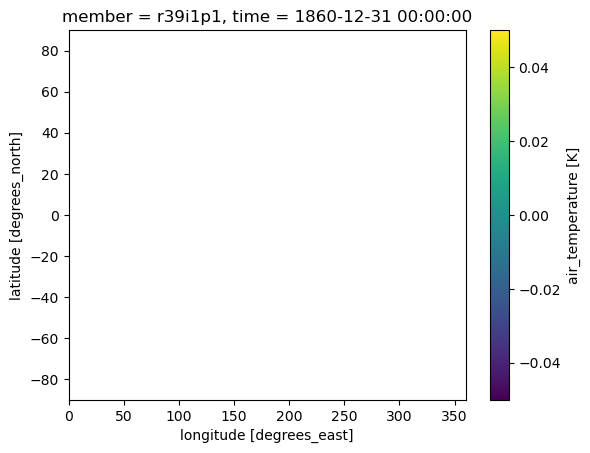

In [89]:
le_ds.isel(time=10, member=30).plot()

In [90]:
le_ds = remove_duplicates_in_dim(le_ds, 'member')

In [91]:
le_ds = le_ds.sel(time=le_ds.time.dt.year>1920)

In [92]:
le_ds_base_period= le_ds.where(le_ds.time.dt.year.isin(np.arange(1920, 1950)), drop=True)

In [93]:
le_ds_base_period_mean = le_ds_base_period.mean(dim='time')

In [94]:
le_anom_ds = le_ds - le_ds_base_period_mean

In [95]:
le_smean_ds = climate_utils.weighted_lat_lon_mean(le_anom_ds).compute()

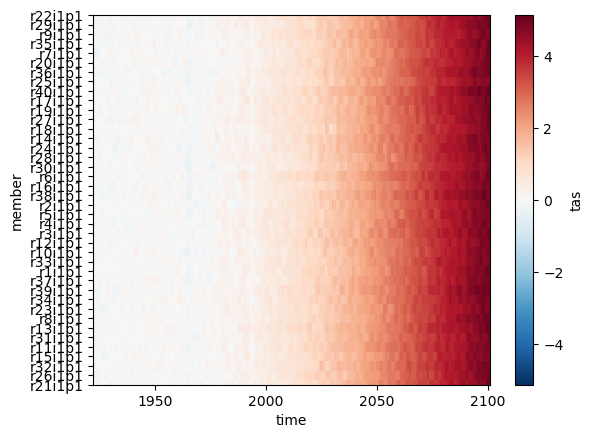

In [96]:
le_smean_ds.plot()

In [97]:
le_smean_base_period_ds = le_smean_ds.where(
    le_smean_ds.time.dt.year.isin(np.arange(1920, 1950)), drop=True)

In [98]:
le_smean_base_period_ds

<xarray.DataArray 'tas' (member: 40, time: 29)> Size: 9kB
array([[-0.00697927,  0.06993293,  0.10298288, ..., -0.05874703,
         0.08759213,  0.11487582],
       [-0.07411831, -0.16820097, -0.08162706, ..., -0.068824  ,
        -0.06299406,  0.10844842],
       [ 0.04616109,  0.04655067,  0.03181169, ...,  0.10828175,
         0.04121381,  0.07625093],
       ...,
       [ 0.03526128, -0.07216592, -0.00527489, ..., -0.08461249,
        -0.08099214,  0.10446601],
       [ 0.03047171, -0.13454122, -0.14201549, ...,  0.09318903,
        -0.04831537, -0.06130825],
       [-0.07463817,  0.08004122,  0.14017601, ..., -0.03734632,
        -0.13197577, -0.08326917]])
Coordinates:
  * member   (member) <U7 1kB 'r21i1p1' 'r26i1p1' ... 'r29i1p1' 'r22i1p1'
  * time     (time) object 232B 1921-12-31 00:00:00 ... 1949-12-31 00:00:00

In [99]:
# le_smean_ads = le_smean_ds.sel(time=le_ds.time.dt.year>1920)

# Local Point

In [100]:
local_loc = dict(lat=-11, lon=--106.64, method='nearest')
#dict(lat=-9.2, lon=-88, method='nearest')

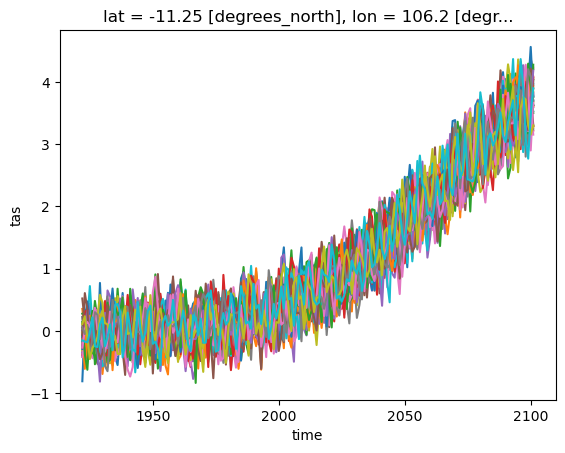

In [101]:
local_point = le_anom_ds.sel(**local_loc).compute()
local_point.plot(hue='member', add_legend=False);

In [102]:
local_signal_ds = xr.apply_ufunc(
    my_stats.apply_lowess, 
    local_point,#.chunk({'time':-1, 'lat':10}), 
    input_core_dims=[['time']],
    output_core_dims=[['time']],
    kwargs=dict(window=41),
    vectorize=True, 
    dask='parallelized',   
    output_dtypes=['float']
).compute()

In [103]:
local_point_detrend = local_point - local_signal_ds
local_sn_lowess_ds = local_signal_ds/local_point_detrend.std(dim='time')

In [104]:
local_toe_sn_5 = toe.get_permanent_exceedance(local_sn_lowess_ds, threshold=5, comparison_func=np.greater)

In [105]:
local_toe_sn_5

<xarray.DataArray 'tas' (member: 40)> Size: 320B
array([2045., 2046., 2041., 2046., 2050., 2045., 2042., 2047., 2047.,
       2042., 2049., 2046., 2047., 2049., 2045., 2042., 2045., 2049.,
       2047., 2039., 2044., 2041., 2039., 2044., 2047., 2048., 2053.,
       2046., 2045., 2051., 2043., 2048., 2045., 2044., 2047., 2050.,
       2050., 2045., 2044., 2043.])
Coordinates:
    lat      float64 8B -11.25
    lon      float64 8B 106.2
  * member   (member) <U7 1kB 'r21i1p1' 'r26i1p1' ... 'r29i1p1' 'r22i1p1'

In [106]:
local_toe_sn_5.min().values.item(), local_toe_sn_5.median().values.item(), local_toe_sn_5.max().values.item()

(2039.0, 2045.5, 2053.0)

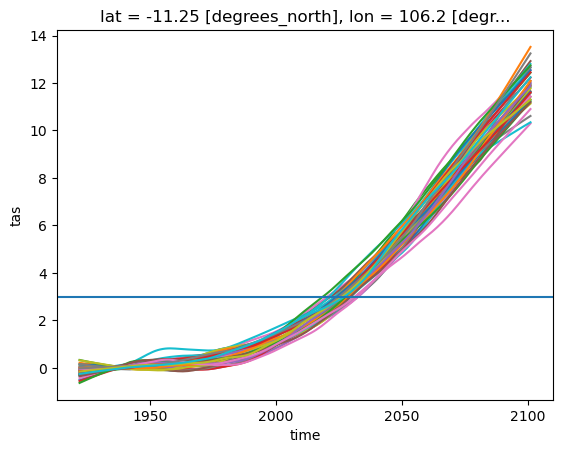

In [107]:
fig, ax = plt.subplots()
local_sn_lowess_ds.plot(hue='member', add_legend=False);
ax.axhline(3)

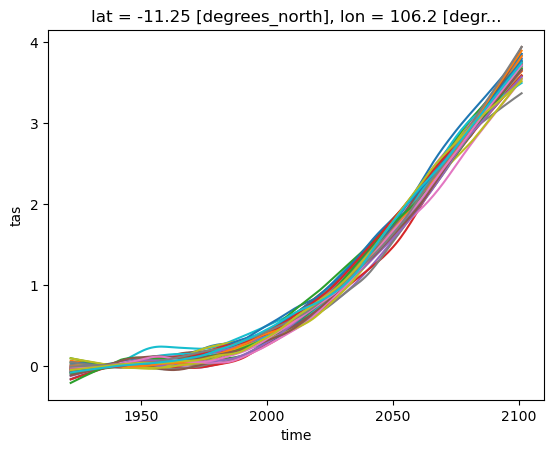

In [108]:
local_signal_ds.plot(hue='member', add_legend=False);

In [109]:
def compute_pct_emergence(toe_values, percentile=50):
    """
    Determines the interpolated year when 50% of ensemble members have emerged.
    
    Parameters:
    toe_values (list or np.array): Array of emergence years, with NaN for non-emerging members.
    
    Returns:
    float: Interpolated year when 50% of members have emerged, or NaN if fewer than 50% emerge.
    """
    toe_values = np.array(toe_values)
    N_threshold = percentile/100 * len(toe_values)  # 50% threshold
    valid_toe = np.sort(toe_values[~np.isnan(toe_values)])
    
    if len(valid_toe) < np.ceil(N_threshold): return np.nan
    
    idx = N_threshold - 1  # 0-based index

    # This occurs when t
    if idx.is_integer():
        return valid_toe[int(idx)]
    
    lower = valid_toe[int(idx)]
    upper = valid_toe[int(idx) + 1]
    weight = idx - int(idx)
    interpolated_value = lower + weight * (upper - lower)
    
    return interpolated_value

In [110]:
local_toe_sn_5.values.copy()

array([2045., 2046., 2041., 2046., 2050., 2045., 2042., 2047., 2047.,
       2042., 2049., 2046., 2047., 2049., 2045., 2042., 2045., 2049.,
       2047., 2039., 2044., 2041., 2039., 2044., 2047., 2048., 2053.,
       2046., 2045., 2051., 2043., 2048., 2045., 2044., 2047., 2050.,
       2050., 2045., 2044., 2043.])

In [111]:
np.median(local_toe_sn_5.values.copy())

2045.5

In [112]:
toe_values = local_toe_sn_5.values.copy()
toe_values_edit = toe_values.copy()
max_value = 2043
toe_values_edit[toe_values_edit>max_value] = max_value#np.nan
toe_values_edit

array([2043., 2043., 2041., 2043., 2043., 2043., 2042., 2043., 2043.,
       2042., 2043., 2043., 2043., 2043., 2043., 2042., 2043., 2043.,
       2043., 2039., 2043., 2041., 2039., 2043., 2043., 2043., 2043.,
       2043., 2043., 2043., 2043., 2043., 2043., 2043., 2043., 2043.,
       2043., 2043., 2043., 2043.])

In [113]:
local_toe_sn_5.min().values.item(), local_toe_sn_5.max().values.item()

(2039.0, 2053.0)

In [114]:
np.sum(toe_values>max_value)

31

In [115]:
compute_pct_emergence(toe_values, 50)

2045.0

In [116]:
compute_pct_emergence(toe_values_edit, 50)

2043.0

In [117]:
# Example Usage
toe_example = [2040, 2035, 2025, np.nan, 2030, 2045, 2038, np.nan, 2032, 2037, np.nan, np.nan]
result = compute_pct_emergence(toe_example)
print("50% Emergence Year:", result)

50% Emergence Year: 2038.0


# GMST

## S/N Ratio

In [118]:
le_smean_signal_ds = xr.apply_ufunc(
    my_stats.apply_lowess, 
    le_smean_ds,#.chunk({'time':-1, 'lat':10}), 
    input_core_dims=[['time']],
    output_core_dims=[['time']],
    kwargs=dict(window=41),
    vectorize=True, 
    dask='parallelized',    
).compute()

In [72]:
le_smean_detrend_ds = le_smean_ds - le_smean_signal_ds

In [73]:
rolling_std = le_smean_detrend_ds.rolling(time=30, center=True).std();

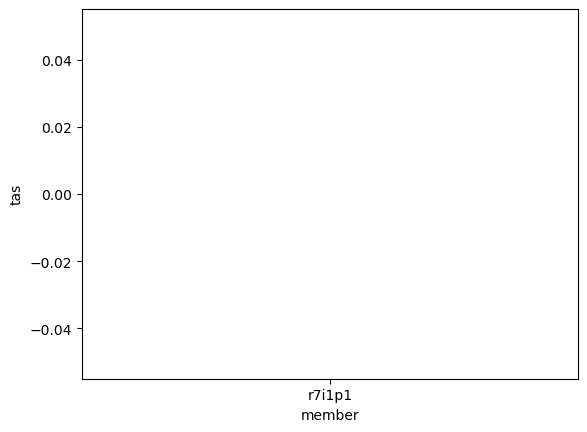

In [74]:
le_smean_detrend_ds.std(dim='time').plot()#bar()

In [511]:
baes_period_std = le_smean_base_period_ds.std(dim='time')

In [512]:
rolling_noise = np.sqrt(1/2*(baes_period_std**2+rolling_std**2))

In [513]:
ds_smean_sn_lowess_rolling_noise = le_smean_signal_ds/rolling_noise

In [514]:
ds_smean_sn_lowess = le_smean_signal_ds/le_smean_detrend_ds.std(dim='time')

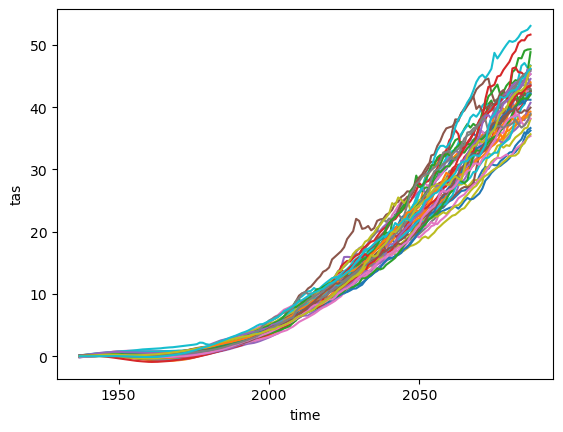

In [515]:
ds_smean_sn_lowess_rolling_noise.plot(hue='member', add_legend=False);

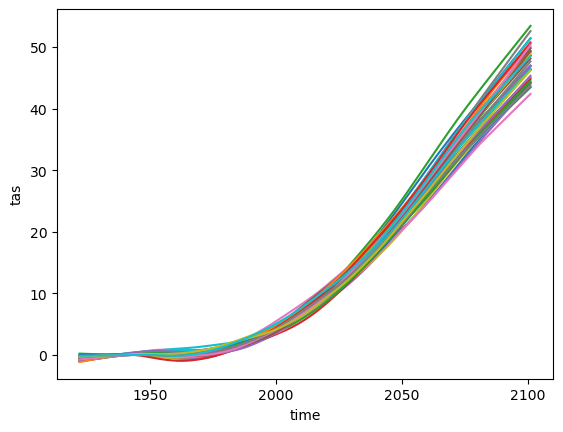

In [508]:
ds_smean_sn_lowess.plot(hue='member', add_legend=False);

## KS test

In [152]:
# The arguements needed for all of the calculations
rolling_window_kwargs = dict(
    input_core_dims=[['window_dim'], ['window_dim']],
    exclude_dims={'window_dim'},
    vectorize=True,
    dask='parallelized')

In [153]:
window = 30

In [154]:
data_ds_window = (le_smean_ds
                  .rolling(time=window, center=True, min_periods=window)
                  .construct('window_dim')
                 ) 

base_period_window_ds = (le_smean_ds.where(le_smean_ds.time.dt.year.isin(np.arange(1920, 1950)), drop=True)
                         .rename({'time':'window_dim'})
                        )

In [472]:
kde_kwargs= dict(bw_method=0.2) # silverman, scott#bw_method=0.2)

frac_geom_ds = xr.apply_ufunc(
    toe.fractional_geometric_area,
    data_ds_window,
    base_period_window_ds,
    kwargs = dict(method_kwargs=kde_kwargs),
    output_dtypes=['float'],
    **rolling_window_kwargs
    ).compute()

In [155]:
%%time
# Expected 3 minutes 30 seconds - best
# 6 23 - era5
ks_ds = xr.apply_ufunc(
        toe.return_ks_pvalue,
        data_ds_window,
        base_period_window_ds,
    **rolling_window_kwargs
    ).compute()

CPU times: user 2.4 s, sys: 480 ms, total: 2.88 s
Wall time: 2.41 s


In [156]:
ttest_ds = xr.apply_ufunc(
        toe.return_ttest_pvalue,
        data_ds_window,
        base_period_window_ds,
    **rolling_window_kwargs
    ).compute()

## Comparisons

In [476]:
import toe_constants

In [479]:
toe_constants.ThresholdProfileLow.overlap_threshold

62

In [480]:
toe_fga = toe.get_permanent_exceedance(frac_geom_ds, threshold=62, comparison_func=np.less)

In [ ]:
ds_smean_sn_lowess_rolling_noise

In [525]:
toe_sn_rolling_1 = toe.get_permanent_exceedance(ds_smean_sn_lowess_rolling_noise.dropna(dim='time'), threshold=1, comparison_func=np.greater)

In [522]:
toe_sn_rolling_1

<xarray.DataArray 'tas' (member: 40)> Size: 320B
array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan])
Coordinates:
  * member   (member) <U7 1kB 'r21i1p1' 'r26i1p1' ... 'r29i1p1' 'r22i1p1'

In [243]:
toe_sn_1 = toe.get_permanent_exceedance(ds_smean_sn_lowess, threshold=1, comparison_func=np.greater)
toe_sn_2 = toe.get_permanent_exceedance(ds_smean_sn_lowess, threshold=2, comparison_func=np.greater)
toe_sn_3 = toe.get_permanent_exceedance(ds_smean_sn_lowess, threshold=3, comparison_func=np.greater)

In [262]:
toe_ks = toe.get_permanent_exceedance(ks_ds, threshold=0.01, comparison_func=np.less)
toe_ttest = toe.get_permanent_exceedance(ttest_ds, threshold=0.01, comparison_func=np.less)

In [263]:
sn_toe_diff = toe_sn_1 - toe_ks
sn_toe_diff_sorted = sn_toe_diff.sortby(np.abs(sn_toe_diff), ascending=False)

In [264]:
np.median(np.abs(sn_toe_diff))

2.0

In [265]:
largest_diff = sn_toe_diff_sorted.isel(member=0)# .member.values.item()
smallest_diff = sn_toe_diff_sorted.isel(member=-1)

In [266]:
largest_diff

<xarray.DataArray 'tas' ()> Size: 8B
array(18.)
Coordinates:
    member   <U7 28B 'r19i1p1'

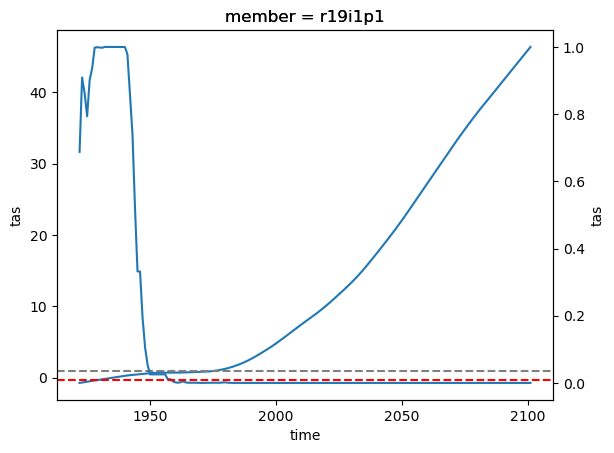

In [267]:
fig, ax = plt.subplots(1, 1)

ds_smean_sn_lowess.sel(member=largest_diff.member.values.item()).plot(ax=ax)
ax.axhline(1, color='grey', linestyle='--')

ax2 = ax.twinx()
ks_ds.sel(member=largest_diff.member.values.item()).plot(ax=ax2)
ax2.axhline(0.01, linestyle='--', color='red')

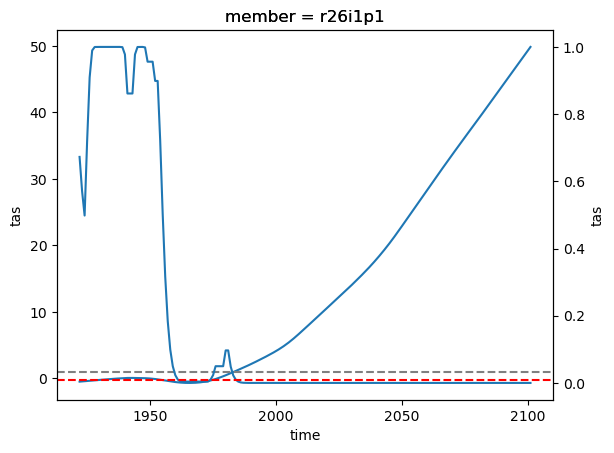

In [268]:
fig, ax = plt.subplots(1, 1)

ds_smean_sn_lowess.sel(member=smallest_diff.member.values.item()).plot(ax=ax)
ax.axhline(1, color='grey', linestyle='--')

ax2 = ax.twinx()
ks_ds.sel(member=smallest_diff.member.values.item()).plot(ax=ax2)
ax2.axhline(0.01, linestyle='--', color='red')

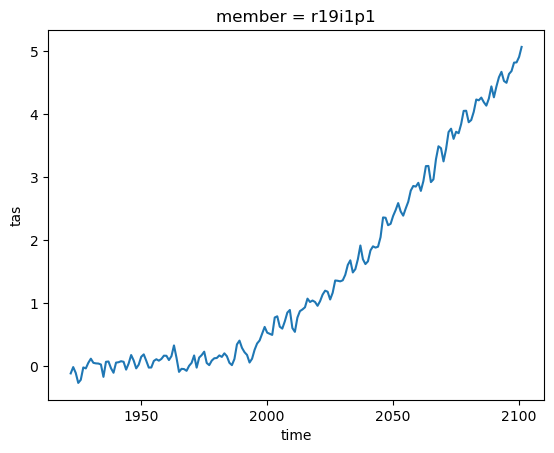

In [233]:
le_smean_ds.sel(member=largest_diff.member.values.item()).plot()

In [234]:
le_anom_ds

<xarray.DataArray 'tas' (member: 40, time: 180, lat: 72, lon: 144)> Size: 597MB
dask.array<sub, shape=(40, 180, 72, 144), dtype=float64, chunksize=(40, 180, 6, 24), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 576B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * lon      (lon) float64 1kB 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * member   (member) <U7 1kB 'r21i1p1' 'r26i1p1' ... 'r29i1p1' 'r22i1p1'
  * time     (time) object 1kB 1921-12-31 00:00:00 ... 2100-12-31 00:00:00

In [235]:
np.std(toe_sn_1), np.std(toe_sn_2), np.std(toe_sn_3)

(<xarray.DataArray 'tas' ()> Size: 8B
 array(4.88204619),
 <xarray.DataArray 'tas' ()> Size: 8B
 array(2.66973781),
 <xarray.DataArray 'tas' ()> Size: 8B
 array(2.25817958))

In [236]:
toe_sn_1.min(), toe_sn_1.max()

(<xarray.DataArray 'tas' ()> Size: 8B
 array(1956.),
 <xarray.DataArray 'tas' ()> Size: 8B
 array(1984.))

In [237]:
np.median(toe_ks), np.std(toe_ks)

(1977.0,
 <xarray.DataArray 'tas' ()> Size: 8B
 array(6.91876976))

In [238]:
np.median(toe_sn_1), np.median(toe_sn_2), np.median(toe_sn_3)

(1977.0, 1986.0, 1992.0)

In [239]:
xdiff, sn_toe_diff_kde = toe.create_kde(sn_toe_diff)

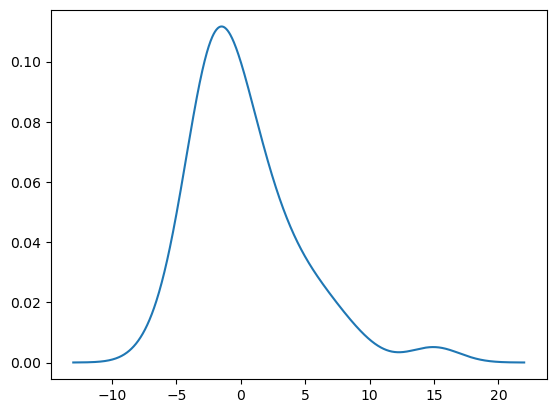

In [240]:
plt.plot(xdiff, sn_toe_diff_kde)

In [453]:
x = np.linspace(1930, 2030, 700)

In [ ]:
toe_fga

In [481]:
_, kde_toe_fga = toe.create_kde(toe_fga, x)

In [527]:
_, kde_toe_rolling_1 = toe.create_kde(toe_sn_rolling_1, x)

In [454]:
_, kde_toe_sn1 = toe.create_kde(toe_sn_1, x)
_, kde_toe_sn2 = toe.create_kde(toe_sn_2, x)
_, kde_toe_sn3 = toe.create_kde(toe_sn_3, x)

_, kde_toe_ks = toe.create_kde(toe_ks, x)
_, kde_toe_ttest = toe.create_kde(toe_ttest, x)

In [462]:
from toe_plots import test_colors

In [463]:
test_colors

{'sn_lowess_base': '#1f77b4',
 'ks': '#ff7f0e',
 'ttest': '#ffa34d',
 'perkins': '#2ca02c',
 'frac': '#8bc34a',
 'hd': '#556b2f'}

In [529]:
# Compute medians of the original data used to generate the KDEs
median_sn1 = np.median(toe_sn_1)
median_ks = np.median(toe_ks)
median_ttest = np.median(toe_ttest)

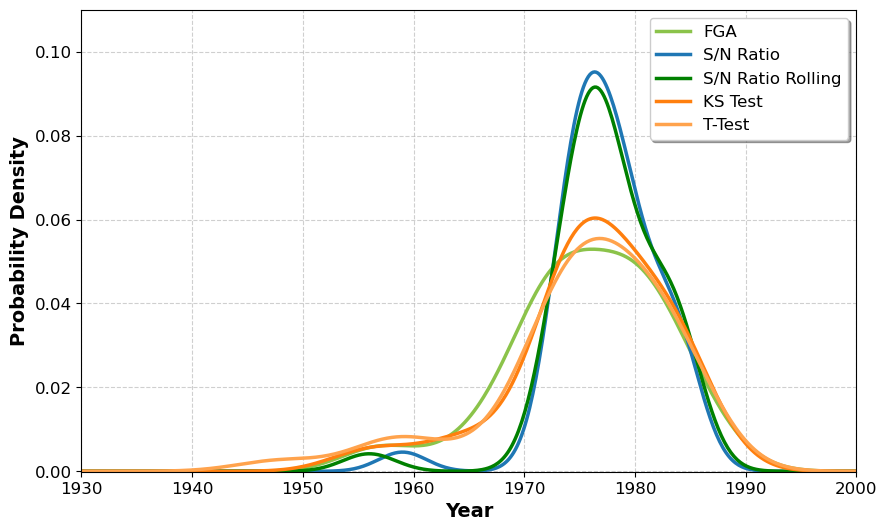

In [531]:
# Create the figure
fig, ax = plt.subplots(figsize=(10, 6))

# Plot with enhanced aesthetics
ax.plot(x, kde_toe_fga, label='FGA', color=test_colors['frac'], linewidth=2.5, linestyle='-')

ax.plot(x, kde_toe_sn1, label='S/N Ratio', color=test_colors['sn_lowess_base'], linewidth=2.5, linestyle='-')
ax.plot(x, kde_toe_rolling_1, label='S/N Ratio Rolling', color='green', linewidth=2.5, linestyle='-')

ax.plot(x, kde_toe_ks, label='KS Test', color=test_colors['ks'], linewidth=2.5)
ax.plot(x, kde_toe_ttest, label='T-Test', color=test_colors['ttest'], linewidth=2.5)


# Set limits
ax.set_xlim(1930, 2000)
ax.set_ylim(-0.0001, 0.11)

# Add labels with styling
ax.set_xlabel('Year', fontsize=14, fontweight='bold')
ax.set_ylabel('Probability Density', fontsize=14, fontweight='bold')

# Customizing grid and ticks
ax.grid(True, linestyle='--', alpha=0.6)
ax.tick_params(axis='both', which='major', labelsize=12)

# Enhanced legend
ax.legend(fontsize=12, loc='upper right', frameon=True, shadow=True, fancybox=True)

(-0.0001, 0.11)

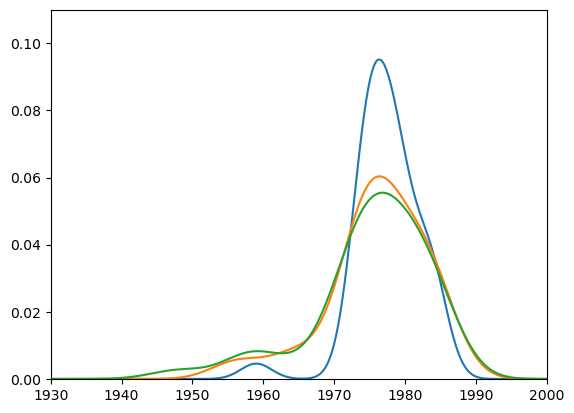

In [456]:
fig, ax = plt.subplots(1, 1)

ax.plot(x, kde_toe_sn1, label='S/N Ratio')
ax.plot(x, kde_toe_ks, label='KS')
ax.plot(x, kde_toe_ttest, label='T-Test')

ax.set_xlim(1930, 2000)

ax.set_ylim(-0.0001, 0.11)

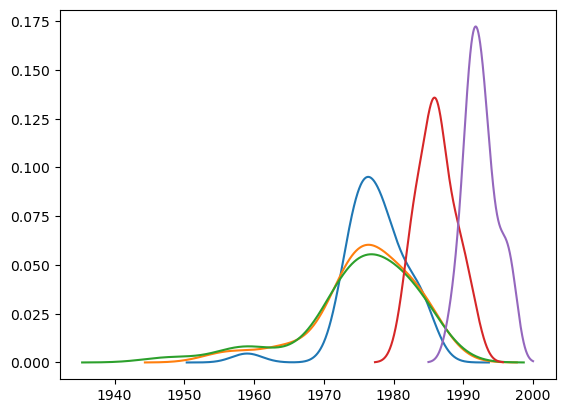

In [170]:
plt.plot(x1, kde_toe_sn1)
plt.plot(x4, kde_toe_ks)
plt.plot(x5, kde_toe_ttest)


plt.plot(x2, kde_toe_sn2)
plt.plot(x3, kde_toe_sn3)

# CEEMDAN

In [36]:
from PyEMD import CEEMDAN

In [37]:
ceedman = CEEMDAN(trials=500)

In [38]:
def return_residual(arr):

    imf_arr = ceedman(arr)

    return imf_arr[-1, :]

In [79]:
def return_all_imf(arr, n_imfs=3):

    imf_arr = ceedman(arr)

    return imf_arr[-n_imfs:, :]

In [81]:
n_imfs = 3

In [97]:
le_smean_ds_ens_mean = le_smean_ds.mean(dim='member').compute()

In [80]:
imf_ds = xr.apply_ufunc(
    return_all_imf,
    le_smean_ds.isel(time=slice(None, -20)).chunk({'member':1}),
    input_core_dims=[['time']], 
    output_core_dims=[['imf', 'time']],
    kwargs = {'n_imfs':n_imfs},
    dask_gufunc_kwargs={'output_sizes': {'imf': 3}},
    vectorize=True,
    dask='parallelized',
    output_dtypes=['float']
).compute()

In [82]:
imf_ds = imf_ds.assign_coords(imf=('imf', np.arange(n_imfs)))

In [93]:
potential_series = imf_ds.isel(imf=slice(-2, None)).sum(dim='imf')
# potential_series = imf_ds.isel(imf=-1)

In [107]:
np.mean((((le_smean_signal_ds - le_smean_ds_ens_mean).values)**2)**(0.5))

0.04626971483231551

In [101]:
np.mean((((potential_series - le_smean_ds_ens_mean).values)**2)**(0.5))

0.05448280066523332

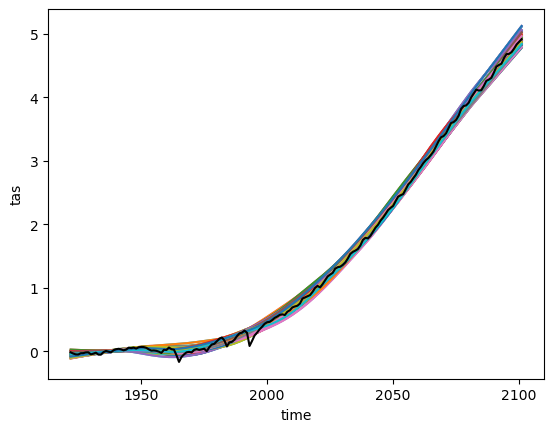

In [106]:
le_smean_signal_ds.plot(hue='member', add_legend=False);
le_smean_ds_ens_mean.plot(color='k')

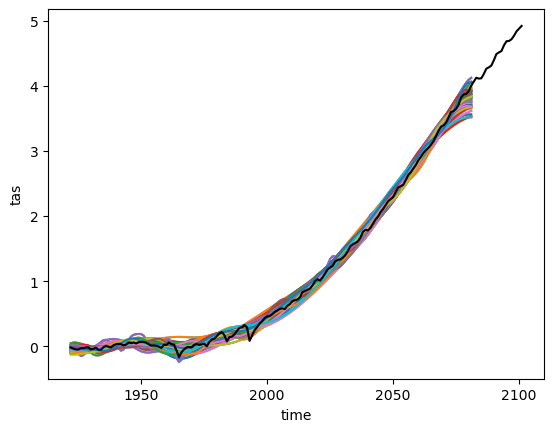

In [98]:
potential_series.plot(hue='member', add_legend=False);
le_smean_ds_ens_mean.plot(color='k')

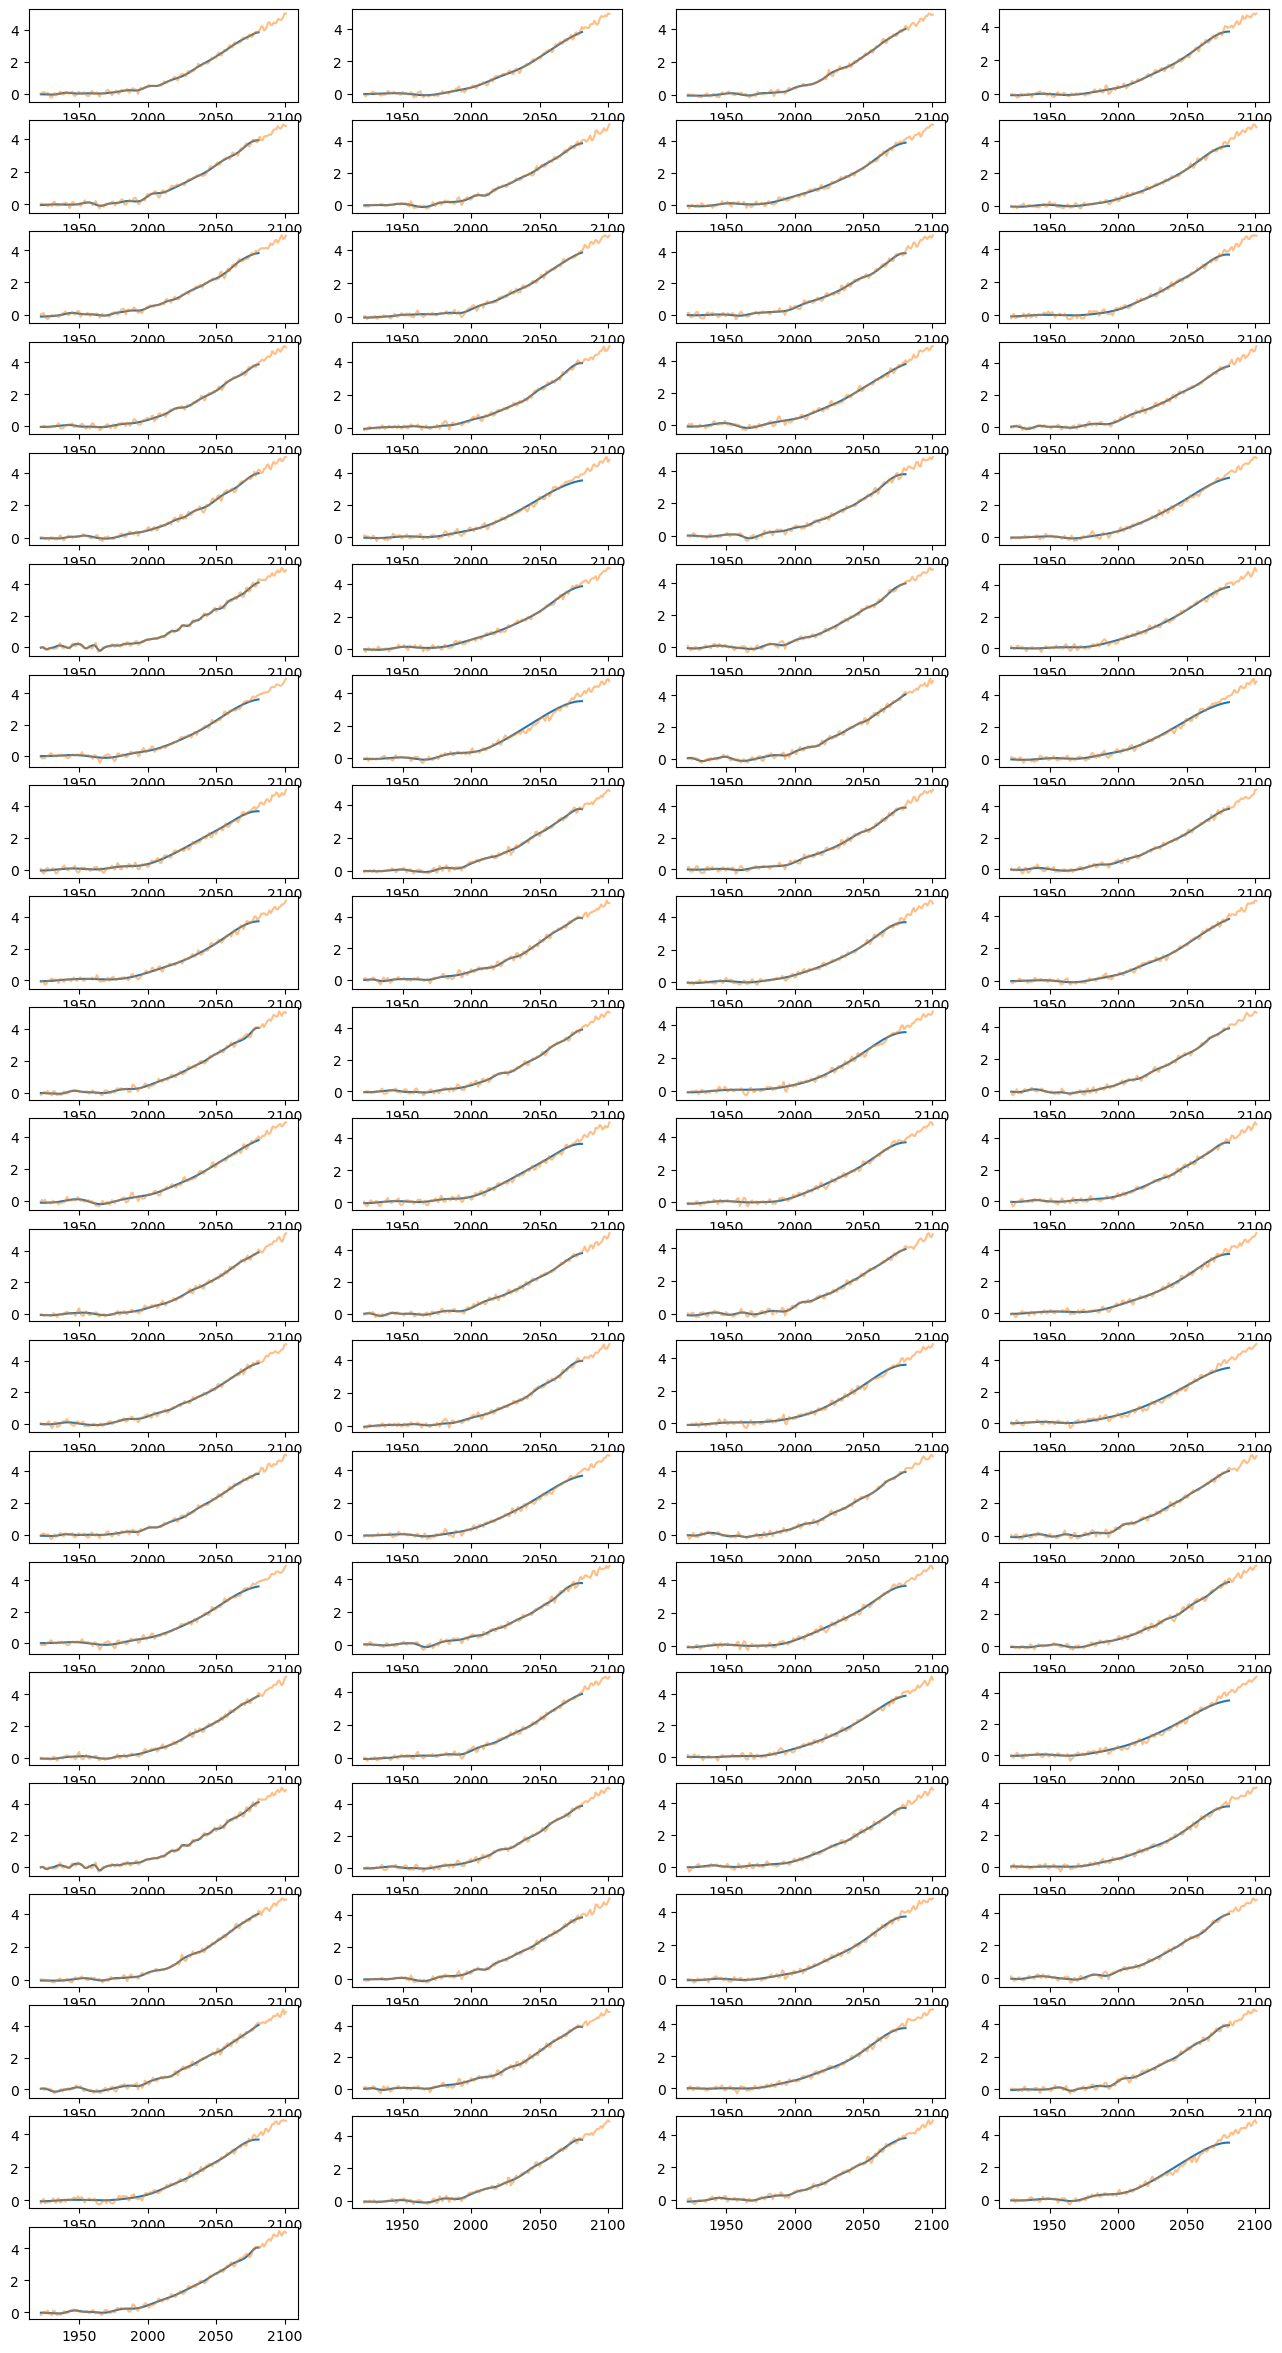

In [95]:
nplots = len(imf_ds.member.values)

ncols = 4
nrows = nplots // ncols + 1

fig = plt.figure(figsize=(16, 30))
gs = gridspec.GridSpec(nrows, ncols)

axes = [fig.add_subplot(gs[i]) for i in range(nplots)]


for num in range(nplots):
    ax = axes[num]

    ax.plot(potential_series.time.values, potential_series.isel(member=num).values)
    ax.plot(le_smean_ds.time.values, le_smean_ds.isel(member=num).values, alpha=0.5)